# Coffee Shop End-to-End Analytics — Python EDA & Profitability Diagnostics

This notebook analyzes coffee shop transactions to quantify overall performance, identify where profit is generated (category + item), when it is generated (hourly pattern), and which products create margin leakage. Results are validated using hypothesis tests to separate volume problems from margin problems.


## Executive Summary

- **Totals:** Revenue = 1857.55, Cost = 247.44, Contribution (Profit) = 1610.11, Overall Margin = 86.68%
- **Profit engine:** Drinks (Hot + Cold) drive the majority of total contribution; Snacks contribute far less.
- **Timing:** Profit concentrates in two windows — **morning (7–9 AM)** and **lunch (12–2 PM)**; post-3 PM contribution declines sharply.
- **Leakage risk:** A small set of products (notably **Hot Chocolate** and **sandwiches**) consume disproportionately higher unit cost and operate at lower margins.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)


## 1. Data Loading

The dataset (`sales_enriched.csv`) is the typed, enriched transaction output aligned with the SQL model. Each row represents an item-level sale with revenue, cost, contribution, and margin fields.


In [4]:
df = pd.read_csv("../01_data/coffee_shop_processed/sales_enriched.csv")
df.head()


,row_id,order_id,created_at,order_date,order_hour,shift_bucket,day_of_week,cust_name,in_or_out,item_id,sku,item_name,item_cat,item_size,quantity,item_price,revenue,unit_cost,total_cost,contribution,margin_pct
0,1,ORD001,12-02-2024 07:04,12-02-2024,7,Morning,Mon,Alex,out,It008,HDR-ESP,Espresso,Hot Drinks,NaN,1,2.15,2.15,0.096,0.096,2.054,95.53%
1,2,ORD002,12-02-2024 07:09,12-02-2024,7,Morning,Mon,Jordan,in,It014,HDR-HCH-LG,Hot Chocolate,Hot Drinks,Large,1,4.60,4.60,1.481,1.481,3.119,67.80%
2,3,ORD003,12-02-2024 07:14,12-02-2024,7,Morning,Mon,Taylor,out,It008,HDR-ESP,Espresso,Hot Drinks,NaN,1,2.15,2.15,0.096,0.096,2.054,95.53%
3,4,ORD004,12-02-2024 07:18,12-02-2024,7,Morning,Mon,Casey,out,It019,CDR-ICT-MD,Iced Tea,Cold Drinks,Medium,1,3.25,3.25,0.190,0.190,3.060,94.15%
4,5,ORD005,12-02-2024 07:23,12-02-2024,7,Morning,Mon,Jamie,out,It024,SNK-SSM,Sandwich Salami&Mozzarella,Snacks,NaN,1,5.50,5.50,1.312,1.312,4.188,76.15%


## 2. Data Quality & Schema Check

We verify dataset shape, column names, data types, and missingness before any analysis to avoid silent errors.



In [3]:
df.shape, df.columns



((466, 21),
 Index(['row_id', 'order_id', 'created_at', 'order_date', 'order_hour',
        'shift_bucket', 'day_of_week', 'cust_name', 'in_or_out', 'item_id',
        'sku', 'item_name', 'item_cat', 'item_size', 'quantity', 'item_price',
        'revenue', 'unit_cost', 'total_cost', 'contribution', 'margin_pct'],
       dtype='object'))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   row_id        466 non-null    int64  
 1   order_id      466 non-null    object 
 2   created_at    466 non-null    object 
 3   order_date    466 non-null    object 
 4   order_hour    466 non-null    int64  
 5   shift_bucket  466 non-null    object 
 6   day_of_week   466 non-null    object 
 7   cust_name     466 non-null    object 
 8   in_or_out     466 non-null    object 
 9   item_id       466 non-null    object 
 10  sku           466 non-null    object 
 11  item_name     466 non-null    object 
 12  item_cat      466 non-null    object 
 13  item_size     385 non-null    object 
 14  quantity      466 non-null    int64  
 15  item_price    466 non-null    float64
 16  revenue       466 non-null    float64
 17  unit_cost     466 non-null    float64
 18  total_cost    466 non-null    

### 2.1 Type Fix — `margin_pct`

`margin_pct` may load as text due to the `%` sign. Convert it to numeric before analysis.



In [6]:
df["margin_pct"] = (
    df["margin_pct"]
    .astype(str)
    .str.replace("%", "", regex=False)
    .astype(float)
)

df["margin_pct"].describe()


count    466.000000
mean      87.690279
std        7.691926
min       64.100000
25%       87.680000
50%       90.400000
75%       91.040000
max       95.530000
Name: margin_pct, dtype: float64

## 3. Business Baseline KPIs

Baseline totals are computed from the full transaction table to quantify overall business performance.



In [7]:
total_revenue = df["revenue"].sum()
total_cost = df["total_cost"].sum()
total_profit = df["contribution"].sum()
overall_margin = (total_profit / total_revenue) * 100

baseline = {
    "Revenue": round(float(total_revenue), 2),
    "Cost": round(float(total_cost), 2),
    "Contribution": round(float(total_profit), 2),
    "Overall Margin %": round(float(overall_margin), 2),
}
baseline



{'Revenue': 1857.55,
 'Cost': 247.44,
 'Contribution': 1610.11,
 'Overall Margin %': 86.68}

## 4. Category Profit Structure

This section compares contribution by category to identify the primary profit engine of the coffee shop.


In [8]:
category_plot = (
    df.groupby("item_cat")[["revenue", "contribution"]]
      .sum()
      .sort_values("contribution", ascending=False)
)

category_plot



,revenue,contribution
item_cat,,
Hot Drinks,1081.20,946.3056
Cold Drinks,582.25,526.7983
Snacks,194.10,137.0040


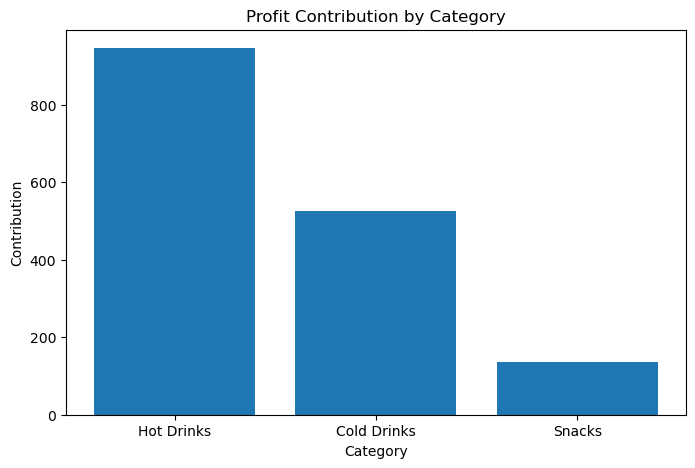

In [9]:
plt.figure(figsize=(8, 5))
plt.bar(category_plot.index, category_plot["contribution"])
plt.title("Profit Contribution by Category")
plt.xlabel("Category")
plt.ylabel("Contribution")
plt.show()


**Interpretation**  
Profit is overwhelmingly generated by beverages (Hot and Cold Drinks), while Snacks contribute only a small share of total contribution. This confirms the café’s economic engine is drink-based rather than food-based.



## 5. Hourly Profit Pattern

We aggregate contribution by hour to identify the daily profit windows and demand-constrained periods.


In [10]:
hour_plot = (
    df.groupby("order_hour")[["contribution"]]
      .sum()
      .sort_index()
)

hour_plot



,contribution
order_hour,
7,239.8573
8,226.4560
9,191.9654
10,78.0719
11,82.9638
12,248.1127
13,243.4576
14,137.7008
15,86.0965


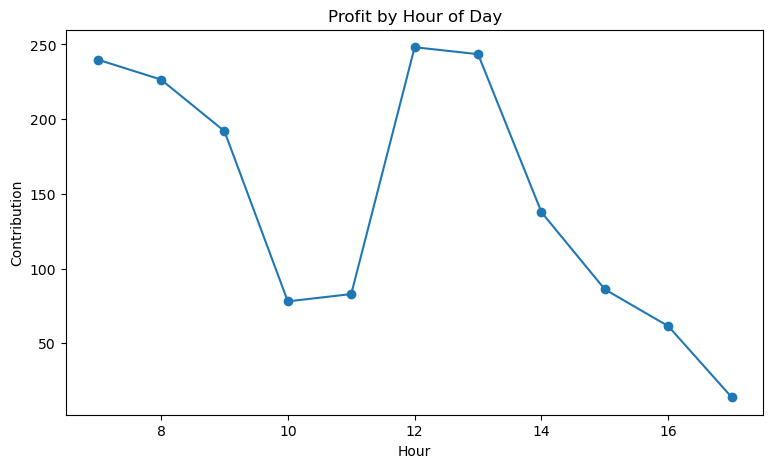

In [10]:
plt.figure(figsize=(9, 5))
plt.plot(hour_plot.index, hour_plot["contribution"], marker="o")
plt.title("Profit by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Contribution")
plt.show()


**Interpretation**  
Profit is concentrated in two daily windows: early morning and lunch hours. After 3 PM, contribution declines sharply, indicating late afternoon and evening are demand-constrained periods rather than margin-constrained.


## 6. Item Profit Concentration (Top 10)

Profit is often concentrated in a small set of menu items. We rank items by total contribution to identify the financial drivers.


In [11]:
item_plot = (
    df.groupby("item_name")[["contribution"]]
      .sum()
      .sort_values("contribution", ascending=False)
      .head(10)
)

item_plot


,contribution
item_name,
Cold Mocha,180.7031
White Mocha,172.6504
Mocha,145.7781
Caramel Macchiato,144.3701
Cappuccino,132.0240
Lemonade,128.2850
Latte,125.6280
Iced Tea,114.7842
Hot Chocolate,109.5550


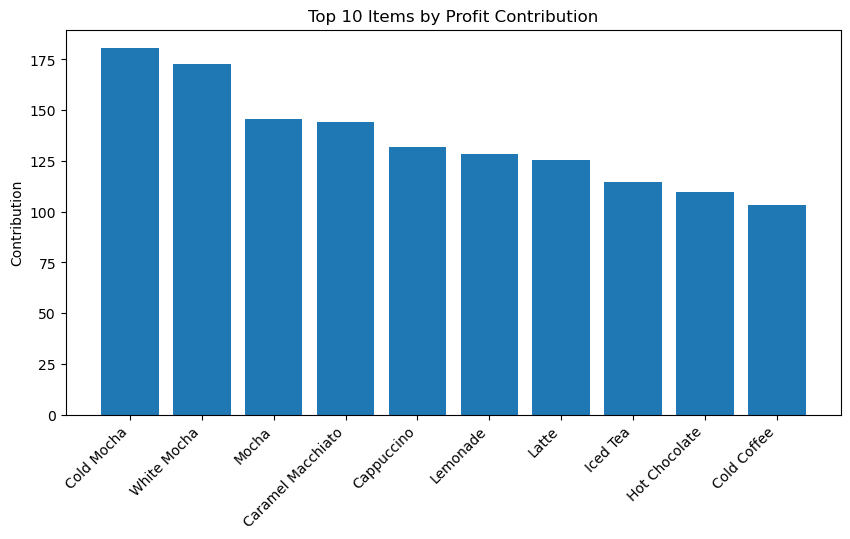

In [12]:
plt.figure(figsize=(10, 5))
plt.bar(item_plot.index, item_plot["contribution"])
plt.title("Top 10 Items by Profit Contribution")
plt.ylabel("Contribution")
plt.xticks(rotation=45, ha="right")
plt.show()



**Interpretation**  
Profit is highly concentrated in a small set of premium and espresso-based drinks (e.g., Cold Mocha, White Mocha, Cappuccino). These items should be prioritized in quality control, availability, and promotions.


## 7. Hypothesis Testing

We use statistical tests to confirm whether observed differences reflect real business structure versus random variation.


### Hypothesis 1 — Drinks vs Snacks Margins

- **H₀ (Null):** Drinks and Snacks have the same average margin.
- **H₁ (Alt):** Drinks and Snacks have different average margins.


In [13]:
drinks = df[df["item_cat"].isin(["Hot Drinks", "Cold Drinks"])]["margin_pct"]
snacks = df[df["item_cat"] == "Snacks"]["margin_pct"]

drinks.describe(), snacks.describe()


(count    431.000000
 mean      89.074756
 std        5.955558
 min       67.800000
 25%       87.940000
 50%       90.400000
 75%       91.720000
 max       95.530000
 Name: margin_pct, dtype: float64,
 count    35.000000
 mean     70.641429
 std       6.090464
 min      64.100000
 25%      64.100000
 50%      76.150000
 75%      76.150000
 max      76.150000
 Name: margin_pct, dtype: float64)

In [14]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(drinks, snacks, equal_var=False)
{"t_stat": round(float(t_stat), 4), "p_value": float(p_value)}


{'t_stat': 17.2484, 'p_value': 5.596199803812942e-20}

**Conclusion**  
The test shows a statistically significant margin difference between Drinks and Snacks (p ≪ 0.001). We reject H₀ and conclude Snacks operate at structurally lower margins than Drinks.


### Hypothesis 2 — Margin by Shift

- **H₀ (Null):** Average margin is the same across Morning, Afternoon, and Evening.
- **H₁ (Alt):** At least one shift has a different average margin.



In [15]:
from scipy.stats import f_oneway

m = df[df["shift_bucket"] == "Morning"]["margin_pct"]
a = df[df["shift_bucket"] == "Afternoon"]["margin_pct"]
e = df[df["shift_bucket"] == "Evening"]["margin_pct"]

f_stat, p_value = f_oneway(m, a, e)
{"f_stat": round(float(f_stat), 4), "p_value": float(p_value)}


{'f_stat': 0.8923, 'p_value': 0.4104259254836754}

**Conclusion**  
The ANOVA does not find a statistically significant difference in margin across shifts (p > 0.05). This indicates lower evening profitability is driven by lower volume (demand), not weaker per-sale margins.


## 8. Risk & Margin Leakage Items

We identify low-margin items to locate where ingredient cost consumes a larger share of selling price.



In [17]:
item_margin = (
    df.groupby("item_name")[["revenue", "total_cost", "contribution"]]
      .sum()
)

item_margin["margin_pct"] = item_margin["contribution"] / item_margin["revenue"] * 100

item_margin.sort_values("margin_pct").head(10)


,revenue,total_cost,contribution,margin_pct
item_name,,,,
Sandwich Ham&Cheese,89.60,32.1680,57.4320,64.098214
Hot Chocolate,155.80,46.2450,109.5550,70.317715
Sandwich Salami&Mozzarella,104.50,24.9280,79.5720,76.145455
Cold Mocha,204.20,23.4969,180.7031,88.493193
Mocha,163.80,18.0219,145.7781,88.997619
Caramel Macchiato,162.20,17.8299,144.3701,89.007460
White Mocha,193.00,20.3496,172.6504,89.456166
Lemonade,142.40,14.1150,128.2850,90.087781
Flat White,85.05,7.7760,77.2740,90.857143


**Interpretation**  
A small number of products, especially sandwiches and Hot Chocolate, operate at substantially lower margins than the rest of the menu. Even when some of these items generate meaningful total profit due to volume, they represent the primary sources of margin leakage.


## 9. Key Takeaways

- The café is primarily a **drink-profit business**; Snacks contribute relatively little to total profit.
- Profit concentrates in **morning and lunch** windows, suggesting staffing and promotions should align to these periods.
- Evening is primarily a **demand problem**, not a margin problem.
- Review **Hot Chocolate and sandwich pricing/recipe cost** as key margin leakage areas.


## 10. Appendix A — Pricing What-If Simulations

These simulations explore how small price changes could impact profitability under realistic demand responses. They do not represent actual observed performance, but rather scenario testing for pricing decisions.

### A1. Hot Chocolate Price Sensitivity (5% price increase, volume unchanged)

In [16]:
price_uplift = 0.05
hot_chocolate = df[df["item_name"] == "Hot Chocolate"]


hc_rev = hot_chocolate["revenue"].sum()
hc_cost = hot_chocolate["total_cost"].sum()
hc_profit = hot_chocolate["contribution"].sum()


hc_rev_new = hc_rev * (1 + price_uplift)
hc_profit_new = hc_rev_new - hc_cost
hc_margin_new = hc_profit_new / hc_rev_new * 100

{
    "hc_rev": round(float(hc_rev), 2),
    "hc_cost": round(float(hc_cost), 2),
    "hc_profit": round(float(hc_profit), 2),
    "hc_rev_new": round(float(hc_rev_new), 2),
    "hc_profit_new": round(float(hc_profit_new), 2),
    "hc_margin_new_pct": round(float(hc_margin_new), 2),
}

{'hc_rev': 155.8,
 'hc_cost': 46.25,
 'hc_profit': 109.56,
 'hc_rev_new': 163.59,
 'hc_profit_new': 117.34,
 'hc_margin_new_pct': 71.73}

### A2. Stress Test — 5% Price Increase with 2% Volume Drop (Whole Business)

In [17]:
price_increase = 0.05
volume_drop = 0.02


base_revenue = df["revenue"].sum()
base_cost = df["total_cost"].sum()
base_profit = df["contribution"].sum()


new_revenue = base_revenue * (1 + price_increase) * (1 - volume_drop)
new_profit = new_revenue - base_cost
profit_change = new_profit - base_profit
profit_change_pct = profit_change / base_profit * 100

{
    "base_revenue": round(float(base_revenue), 2),
    "base_cost": round(float(base_cost), 2),
    "base_profit": round(float(base_profit), 2),
    "new_revenue": round(float(new_revenue), 2),
    "new_profit": round(float(new_profit), 2),
    "profit_change": round(float(profit_change), 2),
    "profit_change_pct": round(float(profit_change_pct), 2),
}

{'base_revenue': 1857.55,
 'base_cost': 247.44,
 'base_profit': 1610.11,
 'new_revenue': 1911.42,
 'new_profit': 1663.97,
 'profit_change': 53.87,
 'profit_change_pct': 3.35}

## Appendix B — Menu Cost Concentration (One-Unit Basket)

This section evaluates how ingredient cost is distributed across the menu by constructing a basket with one unit of every SKU-size combination.



In [20]:
menu_1each = (
df.groupby(["sku", "item_name", "item_size"], as_index=False)
.agg(item_price=("item_price", "median"),
unit_cost=("unit_cost", "median"))
)


menu_1each["one_each_revenue"] = menu_1each["item_price"]
menu_1each["one_each_cost"] = menu_1each["unit_cost"]
menu_1each["one_each_profit"] = menu_1each["one_each_revenue"] - menu_1each["one_each_cost"]


menu_1each[["one_each_revenue","one_each_cost","one_each_profit"]].sum()


one_each_revenue    79.50000
one_each_cost        9.36685
one_each_profit     70.13315
dtype: float64

### B1. Cost Concentration by SKU

In [21]:
cost_rank = (
menu_1each
.sort_values("one_each_cost", ascending=False)
[["sku","item_name","item_size","one_each_cost","one_each_revenue"]]
)

cost_rank.head(10)

,sku,item_name,item_size,one_each_cost,one_each_revenue
12,HDR-HCH-LG,Hot Chocolate,Large,1.4810,4.6
13,HDR-HCH-MD,Hot Chocolate,Medium,1.0510,4.2
2,CDR-CMO-LG,Cold Mocha,Large,0.5667,4.6
10,HDR-CRM-LG,Caramel Macchiato,Large,0.5667,4.6
16,HDR-MOC-LG,Mocha,Large,0.5667,4.6
18,HDR-WMO-LG,White Mocha,Large,0.5667,4.7
3,CDR-CMO-MD,Cold Mocha,Medium,0.4098,4.0
11,HDR-CRM-MD,Caramel Macchiato,Medium,0.4098,4.2
19,HDR-WMO-MD,White Mocha,Medium,0.4098,4.5
17,HDR-MOC-MD,Mocha,Medium,0.4098,4.0


Hot Chocolate (Medium and Large) consumes a disproportionately large share of ingredient cost relative to its price, explaining why it repeatedly appears as a margin-risk product despite generating meaningful absolute profit.
